# QuTiP heat measurement - Qubit-Cavity system

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import qutip

A Hamiltonian for a system of two transmons with the drive can be written as:
$$\hat{H} = \hat{H}_\text{q} + \hat{H}_\text{c} + \hat{H}_\text{int} + \hat{H}_\text{d},$$

where $\hat{H}_\text{q}$, $\hat{H}_\text{c}$ are transmon and cavity hamiltonians, $\hat{H}_\text{int}$ - interaction term, $\hat{H}_\text{d}$ - drive of transmon.

We have already defined the operators for transmons in the previous part. The interaction term can be written as:

$$\hat{H}_\text{int} = С_g V_q V_c.$$
$$V_q = \frac{2e}{C_q}n_q$$
$$V_c = \int_l\vec{E}\:d\vec{l}$$
$$\vec{E}(\vec{r}) = \sum_m\sqrt{\frac{\hbar \omega_m}{2 \varepsilon_0}}(a_m e^{-i \omega_m t}\vec{u}(\vec{r}) + a_m^{\dagger} e^{i \omega_m t}\vec{u}^*(\vec{r}))$$

Using Lumped element approx
$$V_c = \sum_m\sqrt{\frac{\hbar \omega_m}{2 \varepsilon_0}}(a_m e^{-i \omega_m t}\int_l\vec{u}(\vec{r})d\vec{l} + a_m^{\dagger} e^{i \omega_m t}\int_l\vec{u}^*(\vec{r})d\vec{l}) = /\text{for  CPW} / =  \sum_m\sqrt{\frac{\hbar \omega_m}{2 \varepsilon_0}}W(a_m e^{-i \omega_m t} + a_m^{\dagger} e^{i \omega_m t}) $$

So, 
$$H_{int} = J n_q(a_{\omega} e^{-i \omega t} + a_{\omega}^{\dagger} e^{i \omega t} )$$
$$J = C_g \frac{2e}{C_q}W\sqrt{\frac{\hbar \omega}{2 \varepsilon_0}}$$

The drive hamiltonian should also be modified to act on two qubits resulting in (neglecting drive of the resonator):

$$\hat{H}_\text{d} = \alpha n_{q} \cos \omega t\:( + i \alpha n_{q} \sin \omega t )$$

In [3]:
def PlotStateDynamics(result, reference_state, *args, **kwargs):
    """
    Plot the evolution of the state given 
        the result of mesolve
    
    Args:
        state (qobj): state to calculate a scalar product with
        result (obj): result object from mesolve

    """

    plt.ylabel(r"$|\langle \psi(t) | 0 \rangle|^2$", fontsize=16)
    plt.xlabel(r'time', fontsize=16)
    plt.plot(result.times, 
             [np.abs(reference_state.overlap(state))**2 for state in result.states],
              *args, **kwargs)
    
def PlotExpectationDynamics(result, idx=0, *args, **kwargs):
    """
    Plot the evolution of the expectation value given 
        the result of mesolve
    
    Args:
        result (obj): result object from mesolve
        idx (int): index of value in result.expext

    """

    plt.ylabel(r"Charge $\langle n \rangle$", fontsize=16)
    plt.xlabel(r'time', fontsize=16)
    plt.axhline(0, c='k');
    plt.plot(result.times, result.expect[idx], *args, **kwargs)

In [4]:
class Qubit:
    """A convenient class representing qubit and drive parameters"""
    
    def __init__(self, Ec, Esum, d, T1 = 0, T2 = 0, N = 10):
        """
        Args:
            Ec (float): qubit parameter
            Esum (float): sum of Ej parameters in SQUID
            d (float): assymetry coefficient of SQUID
            alpha (float): drive amplitude
            omega (float): drive frequency
            N (int): number of levels in charge basis

        """

        self.Ec = Ec
        self.Esum = Esum
        self.d = d
        self.N = N
        self.w0 = np.sqrt(8*self.get_Ej(0)*self.Ec)
        self.anharmonicity = -self.Ec
        
        #Времена жизни может надо по-итрому задавать
#         self.T1 = T1
#         self.T2 = T2
#         self.Tphi = 0
        
    def __repr__(self):
        self._plot_spectrum()
        return "Transmon qubit \n" + r'plasma freq = ' + str(self.w0) + '\n'\
    + 'anharmonicity = ' + str(self.anharmonicity)
        
    def get_Ej(self, phi_ext):
        """
        Args
            phi_ext (float): external flux (phase)
            
        Returns:
            Ej parameter at a given flux

        """

        return self.Esum*np.abs(np.cos(phi_ext/2))*np.sqrt(1 + self.d**2*np.tan(phi_ext/2)**2)
    
    """We redefine several qutip operators for convenience
       you can just use them as qubit.operator() """
    
    def eye(self):
        return qutip.qeye(2*self.N + 1)
    
    def create(self):
        return qutip.create(2*self.N + 1)
    
    def destroy(self):
        return qutip.destroy(2*self.N + 1)
    
    def num(self):
        return qutip.num(2*self.N + 1)
    
    def tunneling(self):
        return qutip.tunneling(2*self.N + 1, m = 1)
    
    def charge(self):
        return qutip.charge(self.N)
    
    def _energy(self, phi, n):
        Ej = self.get_Ej(phi)
        Ec = self.Ec
        return -Ej + np.sqrt(8*Ej*Ec)*(n + 0.5) - Ec*0.5*(n**2 + n + 0.5)
    
    def hamiltonian(self):
        def H(phi_ext):
            Ej = self.get_Ej(phi_ext)
            
            Htr = 4*self.Ec*self.charge()**2
            Htr += -Ej*0.5*self.tunneling()
            return Htr
        return H
    
    def _plot_spectrum(self):
        
        phi = np.linspace(-1.3*np.pi, 1.3*np.pi, 1000)
        fig,ax = plt.subplots()
        ax.plot(phi, self._energy(phi, 1) - self._energy(phi, 0))
        ax.plot(phi, self._energy(phi, 2) - self._energy(phi, 1))
        plt.plot

Transmon qubit 
plasma freq = 10.0
anharmonicity = -0.25

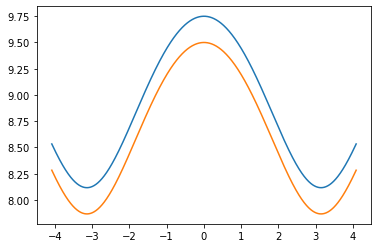

In [5]:
q = Qubit(Ec=1/4, Esum=50, d=0.7, N=1)
q

In [6]:
class Cavity:
    """A convenient class representing qubit and drive parameters"""
    
    def __init__(self, w, N):
        """
        Args:
            w (float): cavity freq
            N (int): number of levels in basis

        """

        self.w = w
        self.N = N


    
    """We redefine several qutip operators for convenience
       you can just use them as qubit.operator() """
    
    def eye(self):
        return qutip.qeye(self.N)
    
    def create(self):
        return qutip.create(self.N)
    
    def destroy(self):
        return qutip.destroy(self.N)
       
    def hamiltonian(self):
        return self.w*(self.create()*self.destroy() + 0.5)


In [7]:
def qsys(qubit, cavity, phi_ext, interaction):
    return qutip.tensor(qubit.hamiltonian()(phi_ext), cavity.eye()) +\
            qutip.tensor(qubit.eye(), cavity.hamiltonian()) + interaction

def interaction(t, qubit, cavity, J):
    w = cavity.w
    a = cavity.destroy()
    n = qubit.charge()
    def time_exp(t):  # coefficient function
#         return np.exp(-1j*args['w']*t)
        return np.exp(-1j*w*t)
#     Hint = J*qutip.tensor(n,[[a, time_exp],[a.dag(), np.conj(time_exp)]])
#     Hint = J*qutip.tensor(n, a + a.dag())
    Hint = J*qutip.tensor(n, a*time_exp(t) + a.dag()*np.conj(time_exp(t)))
    return Hint


    

def plotSystemSpectrum(phi_ext, eigenstates, nfirst=2):
    """Plots the energy spectrum
    
    Args:
        phi_ext (float): qubit parameter.
        eigenstates (obj): qubit eigenstates.
        nfirst (int): number of energy levels to plot.

    """
    fig, ax = plt.subplots()
    for i in range(1,  min(nfirst, len(eigenstates[0, 0, :]))):
        ax.plot(phi_ext/(2*np.pi), eigenstates[:,0,i] - eigenstates[:,0,i-1])
        ax.plot(phi_ext/(2*np.pi), eigenstates[:,0,i+1] - eigenstates[:,0,i-1])
    plt.xlabel(r"External flux $\varphi_{ext}$", fontsize=12)
    plt.ylabel(r"Energy, $E$", fontsize=12)
    plt.show()

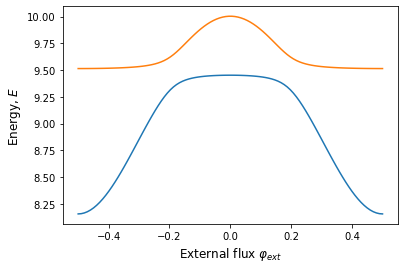

In [8]:
q = Qubit(Ec=1/4, Esum=50, d=0.7, N=5)
c = Cavity(w = 9.5, N = 5)

phi_ext = np.linspace(-np.pi, np.pi, 100)
Hint = interaction(0, q, c, 0.1)

eigenstates = np.array([qsys(q, c, phi_ext, Hint).eigenstates()
                        for phi_ext in phi_ext])
plotSystemSpectrum(phi_ext, eigenstates)

In [ ]:
q = Qubit(Ec=1/4, Esum=50, d=0.7, N=3)
c = Cavity(w = 9.5, N = 3)
phi_ext = 0
times = np.linspace(0, 0.01, 10)

# def H(t, args):
#     Hint = interaction(t, q, c, 0.1)
#     return qsys(q, c, phi_ext, Hint)

Hq = q.hamiltonian()(phi_ext)
Hc = c.hamiltonian()
q_eigenstates = Hq.eigenstates()
c_eigenstates = Hc.eigenstates()

Hint = interaction(0, q, c, 0.1)
H = qsys(q, c, phi_ext, Hint)
eigenstates = H.eigenstates()

# ground_state = qutip.tensor(q_eigenstates[1][0], c_eigenstates[1][1])
ground_state = eigenstates[1][1]
# print(ground_state)

c_ops = []
c_ops.append(np.sqrt(0.01) * qutip.tensor(q.destroy(), c.eye()))

result = qutip.mesolve(H, ground_state,
                    times, c_ops, [q.charge()], args = None,
#                     options=qutip.Options(nsteps=1e5, store_states=True), 
                       progress_bar = True)

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
PlotStateDynamics(result, ground_state)
plt.subplot(1, 2, 2)
PlotExpectationDynamics(result)

### Problem parameters


Here we use units where $\hbar = 1$: 

In [3]:
wc = 1.0  * 2 * np.pi  # cavity frequency
wa = 0.010  * 2 * np.pi  # atom frequency
g  = 0.05 * 2 * np.pi  # coupling strength
kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate
gamma_phi = 0.01    # atom fephasing rate
N = 15              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation ! возможно тут то, что мне надо
use_rwa = False

Q = 100

### Setup the operators, the Hamiltonian and initial state

In [9]:


# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2)) #здесь важно, что фоковские состояния в qutip "развернуты", то есть сигмаz требуется домножать на -1
# также здесь смещение уровня на постоянную величину

# Hamiltonian
def set_H():
    if use_rwa:
        H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
    else:
        H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())
    return H

In [5]:
sm.dag() * sm

Quantum object: dims = [[15, 2], [15, 2]], shape = (30, 30), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0

### Create a list of collapse operators that describe the dissipation

In [6]:
def sd_ohmic(w, w_cutoff = wc, s = 1): # spectral dencity of resistor 
    return w_cutoff*(w/w_cutoff)**s*np.exp(-w/w_cutoff)

def gamma_func(gamma, Q, wa, wc): # это не верно. g не зависит от частоты!
    return gamma/Q*wc**4/((wa**2-wc**2)**2 + wa**4/Q**2)

# n_thermal is defined bubose statistics
def init_c_ops():
    c_ops = []

    # cavity relaxation
    rate = kappa * (1 + n_th_a)
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a)

    # cavity excitation, if temperature > 0
    rate = kappa * n_th_a
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * a.dag())

    # qubit relaxation
#     rate = gamma_func(gamma, Q, wa, wc)
    rate = gamma
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * sm)
    
    # qubit dephasing rate
    rate = gamma_phi
    if rate > 0.0:
        c_ops.append(np.sqrt(rate) * sm.dag() * sm)
    return c_ops

### Evolve the system

Here we evolve the system with the Lindblad master equation solver, and we request that the expectation values of the operators $a^\dagger a$ and $\sigma_+\sigma_-$ are returned by the solver by passing the list `[a.dag()*a, sm.dag()*sm]` as the fifth argument to the solver.

In [12]:
# intial state
wa = 0.01  * 2 * np.pi 
g  = 0.05 * 2 * np.pi
c_ops = init_c_ops()
H = set_H()

psi0 = tensor(basis(N,5), basis(2,1))   

tlist = np.linspace(0,1000,2001)

output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])

## Visualize the results

Here we plot the excitation probabilities of the cavity and the atom (these expectation values were calculated by the `mesolve` above). We can clearly see how energy is being coherently transferred back and forth between the cavity and the atom.

Text(0.5, 1.0, 'Vacuum Rabi oscillations')

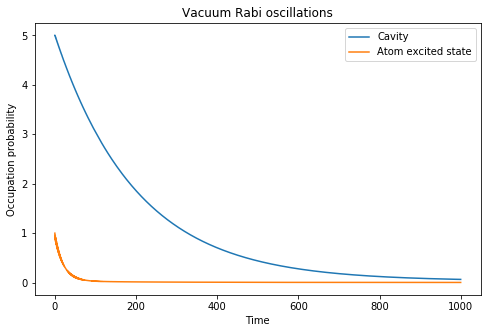

In [13]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(8,5))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom excited state")
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability')
axes.set_title('Vacuum Rabi oscillations')

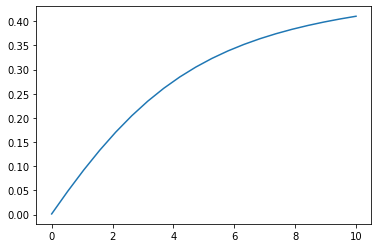

In [39]:
n_th_arr = np.linspace(0,10,20)
psi0 = tensor(basis(N,0), basis(2,0)) 
output = np.array([])
for n_th_a in n_th_arr:
    c_ops = init_c_ops()
    psi0 = tensor(basis(N,5), basis(2,1))   

    tlist = np.linspace(0,1000,1001)

    output = np.append(output, mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm]).expect[1][-1])    
    
plt.plot(n_th_arr, output)

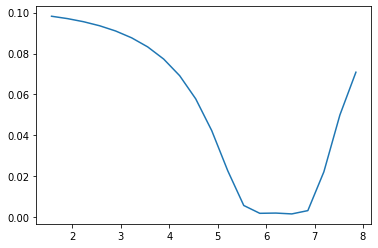

In [84]:
wa_arr = np.linspace(0.25, 1.25, 20) * 2 * np.pi 
psi0 = tensor(basis(N,0), basis(2,0)) 
output = np.array([])
for i in wa_arr:
    wa = i
    c_ops = init_c_ops()
    psi0 = tensor(basis(N,5), basis(2,1))   

    tlist = np.linspace(0,1000,1001)

    output = np.append(output, mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm]).expect[0][-1])    
    
plt.plot(wa_arr, output) # старнно, в модели смена частоты не приводит к смене равновесного состояния

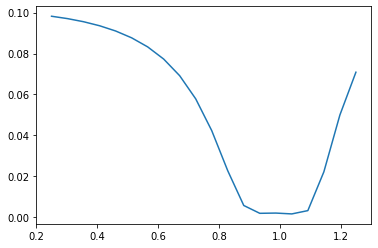

In [88]:
fig, ax = plt.subplots()
ax.plot(wa_arr/2/np.pi, output)
plt.show()

## Cavity wigner function

In addition to the cavity's and atom's excitation probabilities, we may also be interested in for example the wigner function as a function of time. The Wigner function can give some valuable insight in the nature of the state of the resonators. 

To calculate the Wigner function in QuTiP, we first recalculte the evolution without specifying any expectation value operators, which will result in that the solver return a list of density matrices for the system for the given time coordinates.

output = mesolve(H, psi0, tlist, c_ops, [])

Now, `output.states` contains a list of density matrices for the system for the time points specified in the list `tlist`:

output

type(output.states)

len(output.states)

output.states[-1] # indexing the list with -1 results in the last element in the list

Now let's look at the Wigner functions at the point in time when atom is in its ground state: $t = \\{5, 15, 25\\}$ (see the plot above). 

For each of these points in time we need to:

 1. Find the system density matrix for the points in time that we are interested in.
 2. Trace out the atom and obtain the reduced density matrix for the cavity.
 3. Calculate and visualize the Wigner function fo the reduced cavity density matrix.

# find the indices of the density matrices for the times we are interested in
t_idx = where([tlist == t for t in [0.0, 5.0, 15.0, 25.0]])[1]
tlist[t_idx]

# get a list density matrices
rho_list = array(output.states)[t_idx]

# loop over the list of density matrices

xvec = np.linspace(-3,3,200)

fig, axes = plt.subplots(1,len(rho_list), sharex=True, figsize=(3*len(rho_list),3))

for idx, rho in enumerate(rho_list):

    # trace out the atom from the density matrix, to obtain
    # the reduced density matrix for the cavity
    rho_cavity = ptrace(rho, 0)
    
    # calculate its wigner function
    W = wigner(rho_cavity, xvec, xvec)
    
    # plot its wigner function
    axes[idx].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))

    axes[idx].set_title(r"$t = %.1f$" % tlist[t_idx][idx], fontsize=16)
    

At $t =0$, the cavity is in it's ground state. At $t = 5, 15, 25$ it reaches it's maxium occupation in this Rabi-vacuum oscillation process. We can note that for $t=5$ and $t=15$ the Wigner function has negative values, indicating a truely quantum mechanical state. At $t=25$, however, the wigner function no longer has negative values and can therefore be considered a classical state.

### Alternative view of the same thing

t_idx = where([tlist == t for t in [0.0, 5.0, 10, 15, 20, 25]])[1]
rho_list = array(output.states)[t_idx]

fig_grid = (2, len(rho_list)*2)
fig = plt.figure(figsize=(2.5*len(rho_list),5))

for idx, rho in enumerate(rho_list):
    rho_cavity = ptrace(rho, 0)
    W = wigner(rho_cavity, xvec, xvec)
    ax = plt.subplot2grid(fig_grid, (0, 2*idx), colspan=2)
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=plt.get_cmap('RdBu'))
    ax.set_title(r"$t = %.1f$" % tlist[t_idx][idx], fontsize=16)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (1, 1), colspan=(fig_grid[1]-2))
ax.plot(tlist, n_c, label="Cavity")
ax.plot(tlist, n_a, label="Atom excited state")
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability');

### Software versions

from qutip.ipynbtools import version_table

version_table()